In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import corner
from scipy.stats import gaussian_kde

In [2]:
dir = os.getcwd() #path to current working directory 

column_headers = ['x', 'y', 'z', 'vx', 'vy', 'vz', 'm'] #column headers are not included in file
#units in original data file:
#x, y, z: parsecs
#vx, vy, vz: km/s
#m: solar masses

#import data into pandas data frame:
df = pd.read_table(os.path.join(dir,'M5_out_278.00.dat'), names = column_headers) #names option allows manual assigment of column headers


In [3]:
# mks unit converstions factors

G = 6.674*10**-11 #Gravitational constant in mks                                                                                                                                                                          
kg_per_solar = 1.9891*10**30 #mass of sun in kg
m_per_pc = 3.086*10**16 #convert from parsec to meters


In [4]:
# asto unit converstion factors 

G_astro =  4.3*10**-3 #Gravitational constant in (km/s)^2 pc Msun^-1

In [5]:
#convert all data to mks units 

#df.x = df.x * m_per_pc
#df.y = df.y * m_per_pc
#df.z = df.z * m_per_pc
#df.m = df.m * kg_per_solar

Add new columns:

In [6]:
#add column for the radial distance of the star

df['r'] = (df.x**2 + df.y**2 + df.z**2)**(1/2)

In [7]:
#add column for the speed of the star

df['v'] = (df.vx**2 + df.vy**2 + df.vz**2)**(1/2) 

In [8]:
#add column that indicates whether the row contains a star (True) or a black hole (False)

df['star'] = df.m < 200

In [9]:
#add column to indicate which nuclear star cluster the star/bh originated in

iBH2 = df.loc[df['star'] == 0].index[1] #index of second black hole 
df['nsc'] = (df.index >= iBH2) + 1 

In [10]:
df.x.median()

-18.18008

In [11]:
#calculate the center of mass:
xcom = (df.x*df.m).sum() / df.m.sum()
ycom = (df.y*df.m).sum() / df.m.sum()

In [12]:
#center of mass of each cluster

xcom1 = (df.loc[df['nsc'] == 1].x*df.loc[df['nsc'] == 1].m).sum() / df.loc[df['nsc'] == 1].m.sum()
xcom2 = (df.loc[df['nsc'] == 2].x*df.loc[df['nsc'] == 2].m).sum() / df.loc[df['nsc'] == 2].m.sum()
print(xcom1, xcom2)

-8.36205505370907 -11.561701546469408


In [13]:
print(df.iloc[0])
df.iloc[iBH2]

x       -18.2069
y        1.04842
z       0.377924
vx      -288.633
vy       93.9397
vz        9.4443
m          1e+06
r         18.241
v        303.683
star       False
nsc            1
Name: 0, dtype: object


x       -18.2171
y        1.02861
z       0.377476
vx       285.527
vy      -172.526
vz      -12.3155
m          1e+06
r          18.25
v         333.83
star       False
nsc            2
Name: 65537, dtype: object

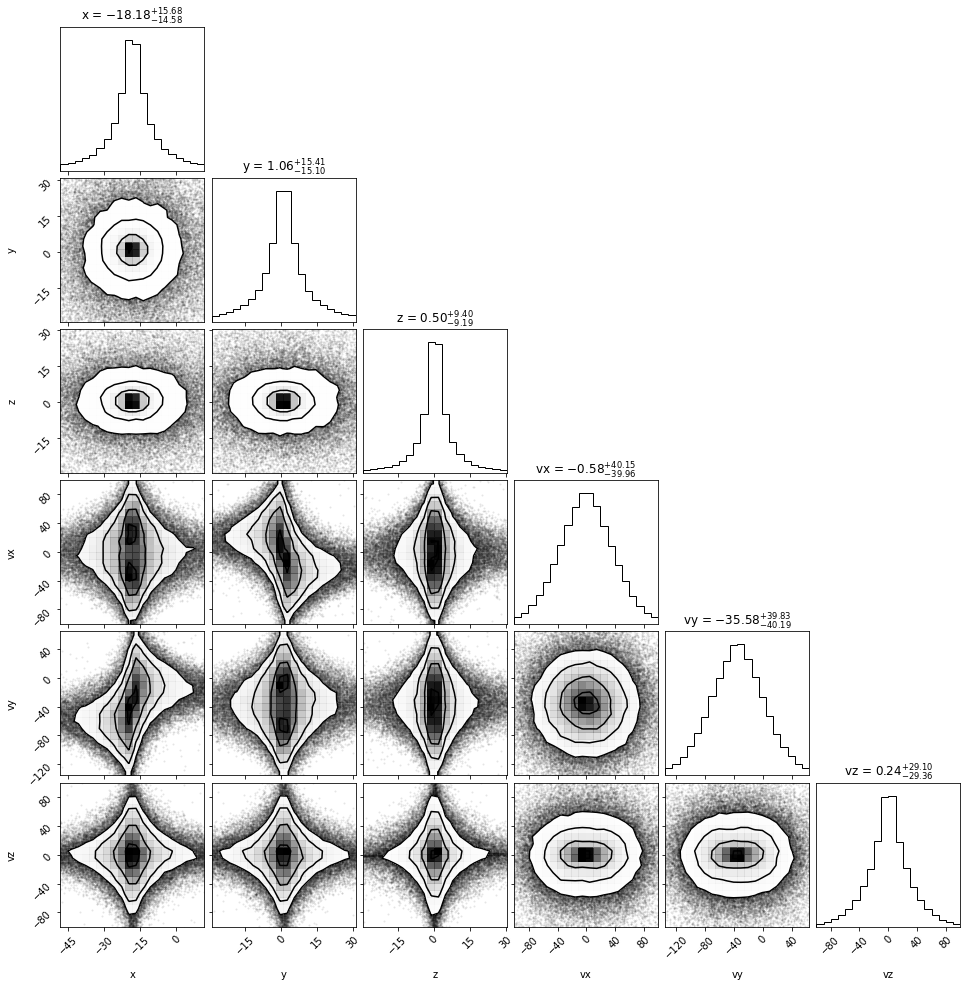

In [14]:

fig = corner.corner(df.loc[df.star==True][['x','y','z','vx','vy','vz']], range = [(df.x.median()-30,df.x.median()+30), (df.y.median()-30,df.y.median()+ 30), (df.z.median()-30, df.z.median()+30), (df.vx.median()-100, df.vx.median()+100), (df.vy.median()-100, df.vy.median()+100), (df.vz.median()-100, df.vz.median()+100)], labels=df.columns.tolist(), show_titles=True, title_fmt=".2f")


In [25]:
xkde = gaussian_kde(df.x, bw_method = .001)
samplex = xkde.resample(size = 131074)[0]

ykde = gaussian_kde(df.y, bw_method = .001)
sampley = ykde.resample(size = 131074)[0]


(array([  13.,   22.,   23.,   13.,   17.,   21.,   30.,   22.,   17.,
          21.,   18.,   25.,   26.,   11.,   21.,   33.,   19.,   18.,
          20.,   17.,   21.,   27.,   19.,   12.,   20.,   26.,   24.,
          25.,   27.,   17.,   25.,   28.,   30.,   26.,   22.,   30.,
          23.,   27.,   23.,   25.,   20.,   26.,   26.,   26.,   37.,
          28.,   34.,   24.,   33.,   32.,   29.,   36.,   33.,   25.,
          30.,   25.,   28.,   29.,   37.,   39.,   30.,   29.,   27.,
          29.,   33.,   21.,   45.,   45.,   37.,   34.,   31.,   35.,
          35.,   30.,   38.,   37.,   37.,   30.,   50.,   52.,   35.,
          38.,   40.,   31.,   48.,   45.,   36.,   52.,   40.,   37.,
          44.,   50.,   41.,   41.,   50.,   47.,   40.,   52.,   47.,
          61.,   52.,   71.,   46.,   46.,   56.,   56.,   52.,   58.,
          49.,   59.,   69.,   47.,   65.,   57.,   48.,   69.,   67.,
          66.,   64.,   61.,   51.,   76.,   62.,   68.,   68.,   53.,
      

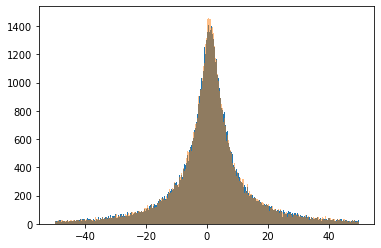

In [26]:

plt.hist(sampley, bins = 500, range = (-50, 50))
plt.hist(df.y, bins = 500, alpha = .5, range = (-50, 50))